In [1]:
# Installing Pillow Libraries
!pip install scikit-learn matplotlib Pillow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import itertools    
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal


In [3]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

In [4]:
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list

In [5]:
dirpath = 'IIIT-CFW/IIIT-CFW/'
X,y = load_data(dirpath)

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)


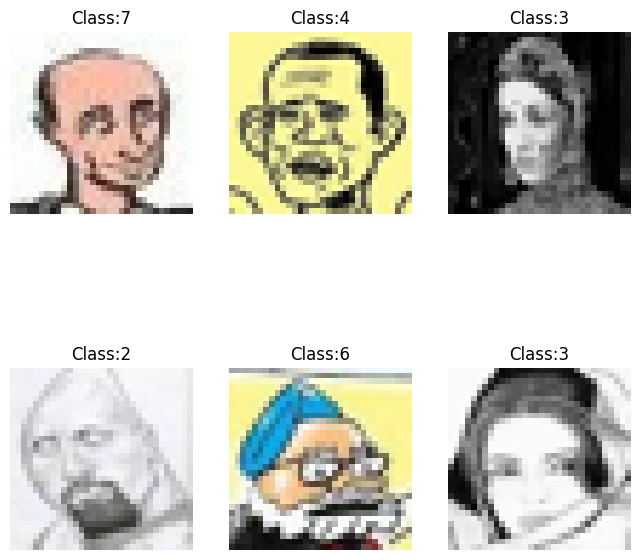

In [13]:
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

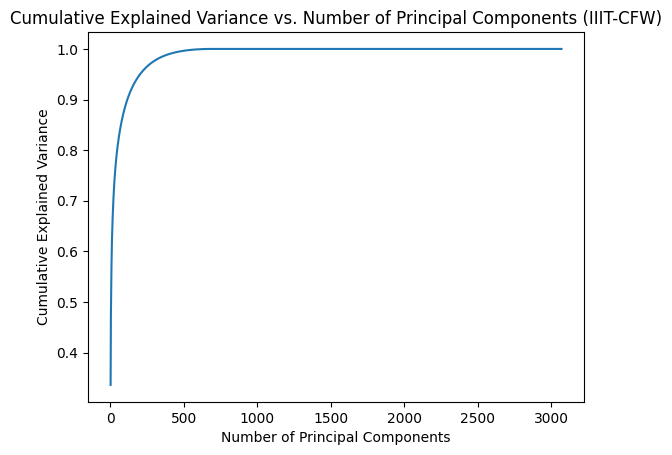

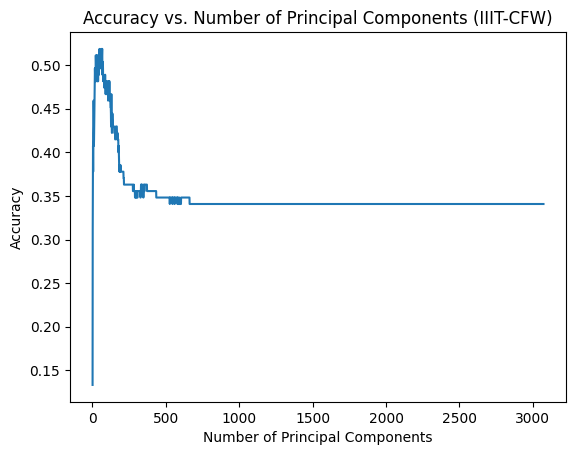

************  Accuracy Scores Data  *********
      Number of Principal Components  Accuracy
0                                  1  0.133333
1                                  2  0.311111
2                                  3  0.348148
3                                  4  0.407407
4                                  5  0.377778
...                              ...       ...
3067                            3068  0.340741
3068                            3069  0.340741
3069                            3070  0.340741
3070                            3071  0.340741
3071                            3072  0.340741

[3072 rows x 2 columns]


In [6]:
X_flat = X.reshape(X.shape[0], -1)

class CustomPCA:
    def __init__(self, n_components):
        self.n_components = n_components
    def fit(self, X):
        mean = np.mean(X, axis=0)
        X_normal = np.subtract(X, mean)
        cov = np.matmul(X_normal.T, X_normal)
        eigenvalues, eigenvectors = np.linalg.eig(cov)
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        self.eigenvalues_ = eigenvalues
        eigenvectors = eigenvectors[:,idxs]
        return eigenvectors#[:, :self.n_components]

    def transform(self, X):
        eigenvectors = self.fit(X)
        return np.dot(X, eigenvectors)
    
    def cumulative_explained_variance_ratio(self):
        total_variance = np.sum(self.eigenvalues_)
        explained_variances = self.eigenvalues_ / total_variance
        cumulative_variances = np.cumsum(explained_variances)
        return cumulative_variances

pca = CustomPCA(n_components=X_flat.shape[1])
X_reduced = pca.transform(X_flat)
X_real = np.real(X_reduced)
cumulative_variances = np.real(pca.cumulative_explained_variance_ratio())
no_of_features = X_flat.shape[1]
accuracies = []

for n_components in range(1, no_of_features+1):
    X_train, X_val, y_train, y_val = train_test_split(X_real[:, :n_components], y, test_size=0.2, random_state=42)
    
    kNN = KNeighborsClassifier()
    kNN.fit(X_train, y_train)
    y_pred = kNN.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracies.append(accuracy)

plt.plot(range(1, no_of_features+1), cumulative_variances)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components (IIIT-CFW)')
plt.show()

plt.plot(range(1, no_of_features+1), accuracies)
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Principal Components (IIIT-CFW)')
plt.show()

print("************  Accuracy Scores Data  *********")
accuracies_data = {
    "Number of Principal Components": range(1, no_of_features+1),
    "Accuracy": accuracies,
}
acc_data = pd.DataFrame(accuracies_data)
print(acc_data)



### 1.1.4 Observations:

<ol>
<li>The accuracy of the KNN classifier reaches its highest value (0.51) in the range of n_components from 40 to 50 (Peak at 48). This indicates that, by retaining the most informative components, we can to improve the model's accuracy.</li>
<br>
<li>The peak accuracy at n_components = 40 to 50 suggests that these components contain the most valuable information for classification tasks. These components capture the essential patterns and structures in the data.</li>
<br>
<li>Beyond the optimal range (n_components > 50), the accuracy starts to decrease. This decrease is expected because we are bringing into focus some un-important information by changing the dimensionality from optimal value.</li>
</ol>

     F1 Score  Accuracy  Precision    Recall
0    0.000980  0.003333   0.465547  0.162420
1    0.002306  0.006667   0.418239  0.172082
2    0.013060  0.030000   0.498807  0.188155
3    0.028065  0.053333   0.495608  0.178788
4    0.026167  0.053333   0.451706  0.196238
..        ...       ...        ...       ...
295  0.124145  0.216667   0.513144  0.282379
296  0.124145  0.216667   0.513144  0.282379
297  0.124145  0.216667   0.519680  0.282379
298  0.124145  0.216667   0.513144  0.282379
299  0.124145  0.216667   0.513144  0.282379

[300 rows x 4 columns]


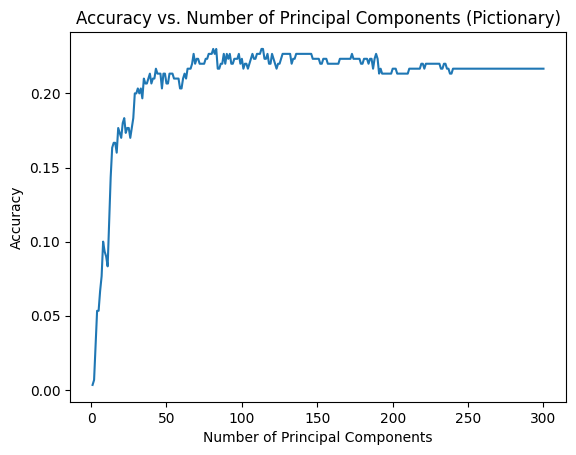

In [8]:
data = np.load('data.npy', allow_pickle=True)
y_pic = data[:, 3]

vit_data = np.concatenate(data[:, 2], axis=0)
max_features = 300
pca_pictionary = CustomPCA(n_components=data.shape[1])
vit_reduced = pca_pictionary.transform(vit_data)
scores_pictionary = np.array([])

for n_components in range(1, max_features+1):
    vit_train, vit_val, y_train, y_val = train_test_split(vit_reduced[:, :n_components], y_pic, test_size=0.2, random_state=42)

    kNN = KNeighborsClassifier()
    kNN.fit(vit_train, y_train)
    y_pred = kNN.predict(vit_val)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=True)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='macro', zero_division=True)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=True)
    if(n_components == 1):
        scores_pictionary = np.array([f1, accuracy, precision, recall])
    else:
        scores_pictionary = np.vstack((scores_pictionary, np.array([f1, accuracy, precision, recall])))
    
scores_data = {
    "F1 Score": scores_pictionary[:, 0],
    "Accuracy": scores_pictionary[:, 1],
    "Precision": scores_pictionary[:, 2],
    "Recall": scores_pictionary[:, 3],
}
dataframe = pd.DataFrame(scores_data)
print(dataframe)
plt.plot(range(1, max_features+1), scores_pictionary[:, 1])
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Principal Components (Pictionary)')
plt.show()

def read_data(dir_path, start, end):
    df = pd.read_csv(dir_path)
    features = np.array(df.columns)[start:end]
    data = df.to_numpy()[:, start:end]
    return data, features



### 1.1.3 Observations:

<ul>
<li>The accuracy values of pictionary dataset ranged from 0.23 to 0.29 (top-20 values) in assignment-1, i.e, without doing PCA.</li>
<br>
<li>But after doing PCA, the accuracy values are ranging from 0.003 to 0.23. The accuracies are increasing as the number of principal components are increasing from 1 to 100. As we can see, the accuracies are still close to the values before PCA.</li>
<br>
<li>Hence, PCA has a positive impact on the model's accuracy since it effectively reduces the dimensionality of the dataset, without having to sacrifice a lot on accuracy.</li>
<br>
<li>Performance Trade-off: While PCA improves some performance metrics, it's essential to consider the trade-off between dimensionality reduction and information loss, and choose the optimal value of number of components. Optimal number of components can be chosen from the above graph. By varying the components over a range of values, we can choose the value where accuracy is at local maximum. </li>
</ul>


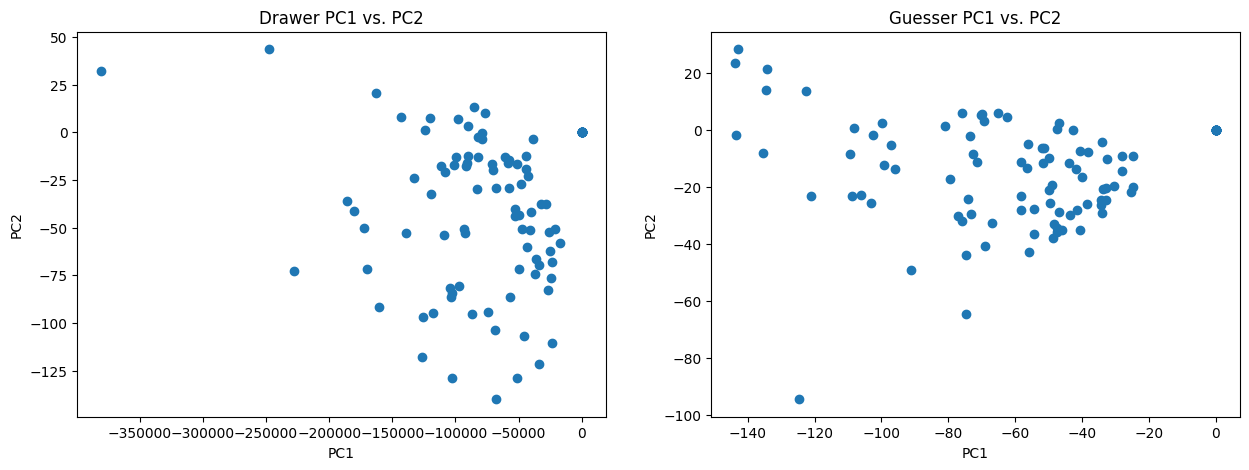

Text(0.5, 0.92, '3D Scatter Plot of Guesser for PC1, PC2 and PC3')

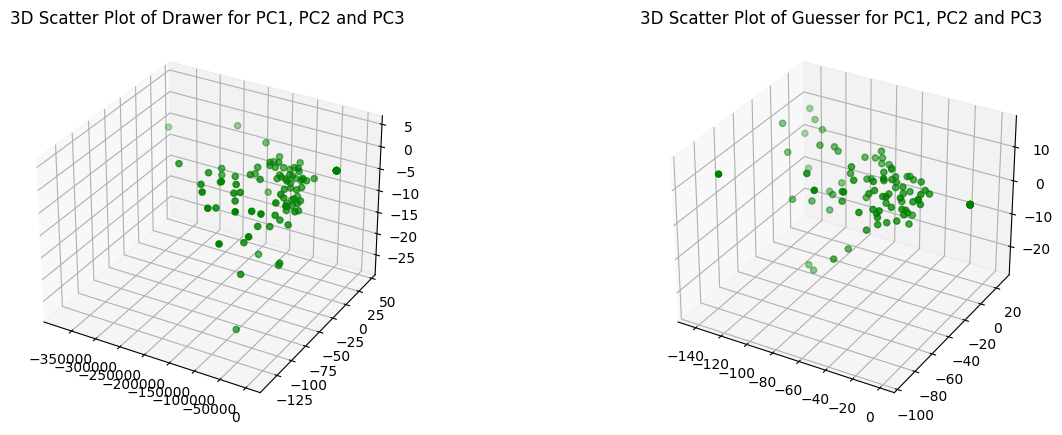

In [19]:
drawer_path = './smai_assignment_pictionary/drawer_attributes.csv'
drawer_data, drawer_features = read_data(drawer_path, 0, 9)
drawer_data = np.delete(drawer_data, 0, 1)

guesser_path = './smai_assignment_pictionary/guesser_attributes.csv'
guesser_data, guesser_features = read_data(guesser_path, 0, 7)
guesser_data = np.delete(guesser_data, 0, 1)

drawer_pca = CustomPCA(n_components=drawer_data.shape[1])
drawer_reduced = drawer_pca.transform(drawer_data)

guesser_pca = CustomPCA(n_components=guesser_data.shape[1])
guesser_reduced = guesser_pca.transform(guesser_data)

d_pc1 = drawer_reduced[:, 0]
d_pc2 = drawer_reduced[:, 1]
d_pc3 = drawer_reduced[:, 2]

g_pc1 = guesser_reduced[:, 0]
g_pc2 = guesser_reduced[:, 1]
g_pc3 = guesser_reduced[:, 2]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(d_pc1, d_pc2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Drawer PC1 vs. PC2')

plt.subplot(1, 2, 2)
plt.scatter(g_pc1, g_pc2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Guesser PC1 vs. PC2')
plt.show()


fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
 
ax.scatter3D(d_pc1, d_pc2, d_pc3, color = "green")
plt.title("3D Scatter Plot of Drawer for PC1, PC2 and PC3")
 
ax = plt.subplot(1, 2, 2, projection='3d')

ax.scatter3D(g_pc1, g_pc2, g_pc3, color = "green")
plt.title("3D Scatter Plot of Guesser for PC1, PC2 and PC3")

### 1.2.2 Observations:

<b>Note:</b>
<p>The First column in the both drawer's data and guesser's data which represents ID, is removed since it has no significant information </p>
<h3>Conclusions for drawer plots: </h3>
<ol>
<li>
From the plot of PC1 and PC2, we can see that the values of PC1 are in the order of the feature <b>d_area_median</b>. This implies that it is the most significant attribute which can retain most of the information in the original data.
</li>
<br>
<li>
PC2 values are in the range of feature <b>d_rangestroketime_median</b> and <b>d_laststroketime_median</b>
Hence it could be a mixture of these two components
</li>
<br>
<li>
From the plot of PC1, PC2 and PC3, we can see that PC3 values lie from -25 to 5, indicating that they are a mix of the features with values in that range, which are <b>d_rangestroketime_median</b>,  <b>d_firststroketime_median</b> and <b>d_laststroketime_median</b>
</li>
</ol>
<br>
<h3>Conclusions for guesser plots: </h3>
<ol>
<li>
From the plot of PC1 and PC2, we can see that the values of PC1 are in the order of the feature <b>g_rangemessagetime_median</b>, <b>d_firststroketime_median</b> and <b>d_laststroketime_median</b>. This implies that PC1 is a mixture of these three features. (The values of those features are also in the same range). Also, the PC2 values belong to the same range which means that PC2 is also a mixture of <b>g_rangemessagetime_median</b>, <b>d_firststroketime_median</b> and <b>d_laststroketime_median</b>
</li>
<br>
<br>
<li>
From the plot of PC1, PC2 and PC3, PC3 values lie from -20 to 10. This indicates that they are a mixture of <b>g_noofmessage_median</b>, <b>g_rangemessagetime_median</b>, <b>d_firststroketime_median</b> and <b>d_laststroketime_median</b>
</li>
</ol>

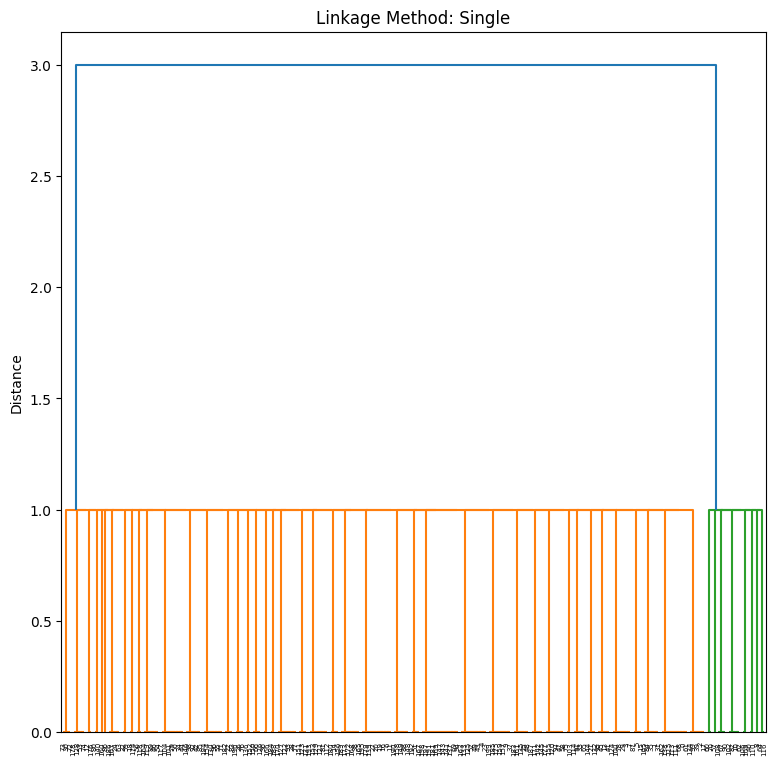

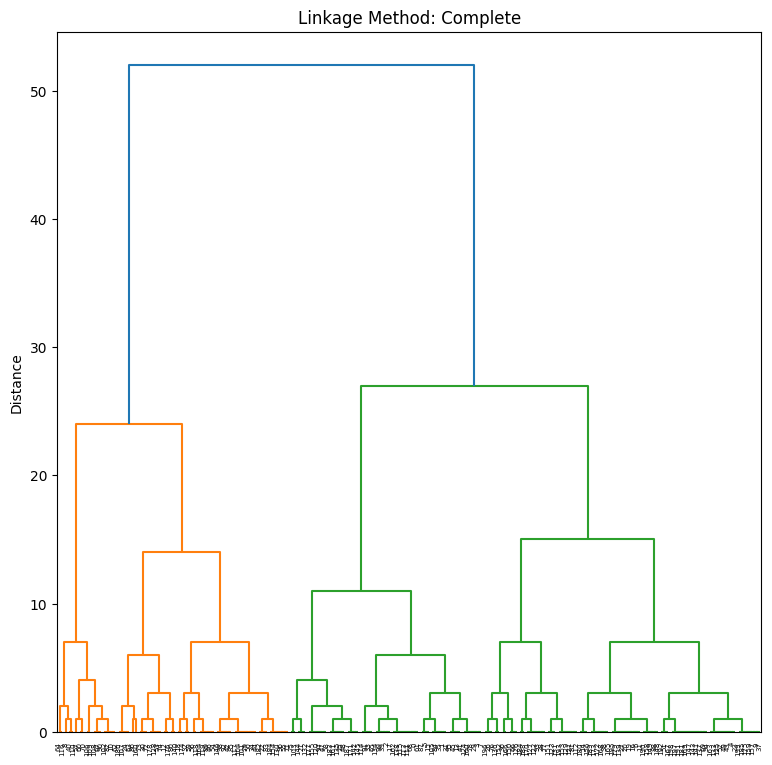

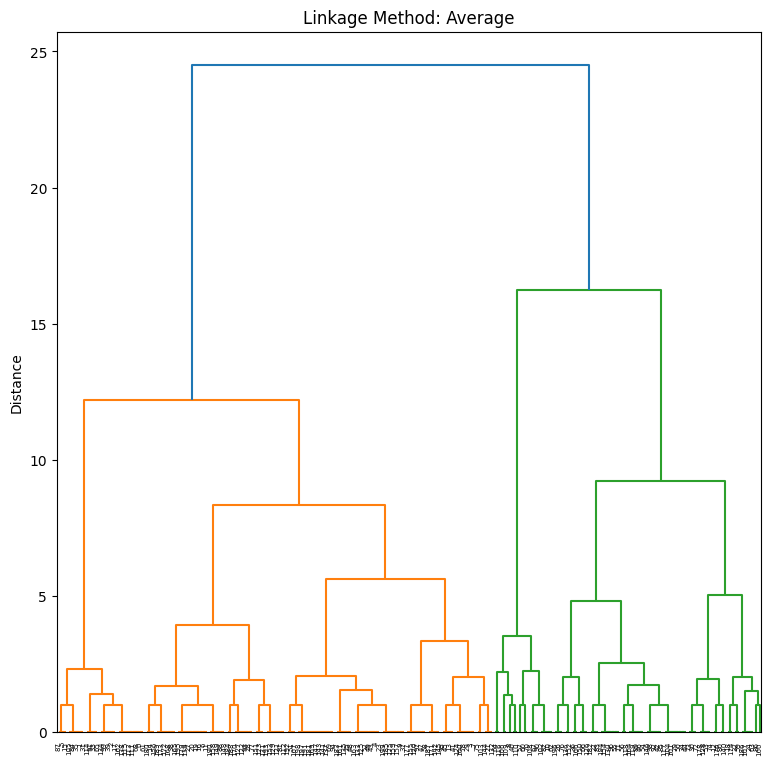

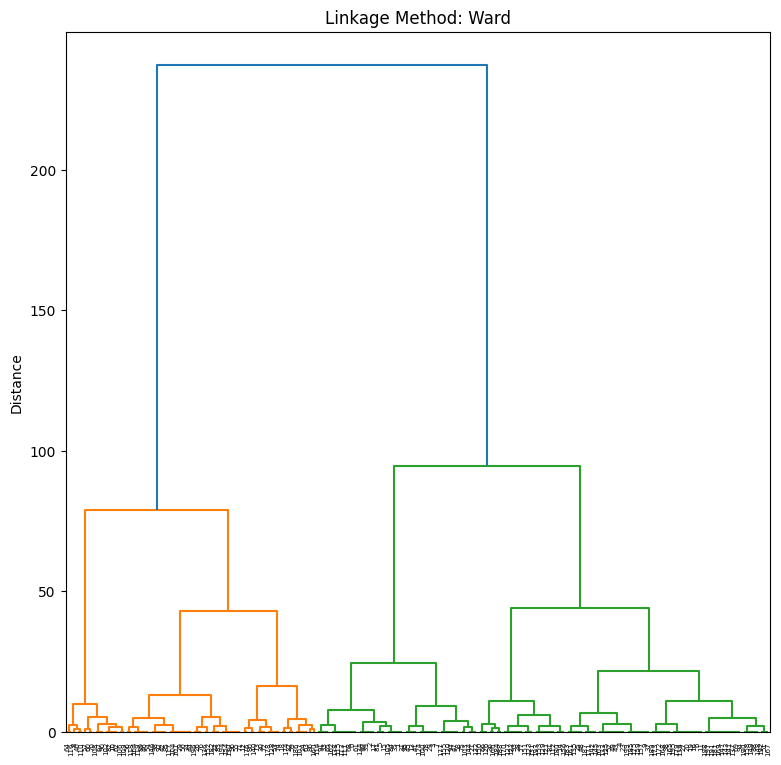

In [53]:

def generate_power_set(features):
    power_set = list(itertools.chain.from_iterable(itertools.combinations(features, r) for r in range(len(features) + 1)))
    power_set_cleaned = [list(element) for element in power_set]
    power_set_sorted = list(map(sorted, power_set_cleaned))
    power_set_sorted.sort()
    power_set_sorted.sort(key=lambda x: len(x))
    power_set_sorted.pop(0)
    return power_set_sorted

def generate_feature_indices(feature_set, features_dict):
    feature_indices = []
    for feature in feature_set:
        feature_indices.append(features_dict[feature])
    return feature_indices

def generate_feature_dict(features):
    features_dict = {}
    for i, feature in enumerate(features):
        features_dict[feature] = i
    return features_dict

def plot_dendrograms(linkage_methods, features_dict, power_set_sorted, data):
    itr = 1
    #plt.figure(figsize=(12, 8))
    for method in linkage_methods:
        for feature_set in [power_set_sorted[0]]:
            feature_indices = generate_feature_indices(feature_set, features_dict)
            hc = HeirarchicalClustering(feature_indices)
            linkage_matrix = hc.linkages(data, method)
            plt.figure(figsize=(20, 20))
            plt.subplot(2, 2, itr)
            itr += 1
            plt.title(f'Linkage Method: {method.capitalize()}')
            plt.ylabel('Distance')
            hc.Dendrogram(linkage_matrix)

class HeirarchicalClustering():
    def __init__(self, features_used):
        self.features_used = features_used
        
    
    def fit(self, X):
        self.data = X[:, self.features_used]        

    def linkages(self, X, linkage_type):
        self.fit(X)
        linkage_matrix = linkage(self.data, method=linkage_type)
        return linkage_matrix
    
    def Dendrogram(self, linkage_matrix):
        dendrogram(linkage_matrix)

linkage_methods = ['single', 'complete', 'average', 'ward']

hc_data_path = './SMAI-Dataset-hc-dataset/new_customers.csv'
hc_data, hc_features = read_data(hc_data_path, 2, 5)

hc_power_set_sorted = generate_power_set(hc_features)
hc_features_dict = generate_feature_dict(hc_features)

plot_dendrograms(linkage_methods, hc_features_dict, hc_power_set_sorted, hc_data)


### 3.1.1 Obeservations:

<ol>
<li><b>Single Linkage:</b>We can observe that single linkage seems to produce long and irregularly growing clusters.</li>
<br>
<li><b>Complete Linkage:</b>We can observe that complete linkage seems to produce balanced and structured clusters.</li>
<br>
<li><b>Average Linkage:</b>From the dendogram of average linkage, we can infer that it is a compromise of both single and complete linkages since it is slightly long as well as structured.</li>
<br>
<li><b>Ward Linkage:</b>Ward linkage minimizes the variance of distances within each cluster.</li>
</ol>

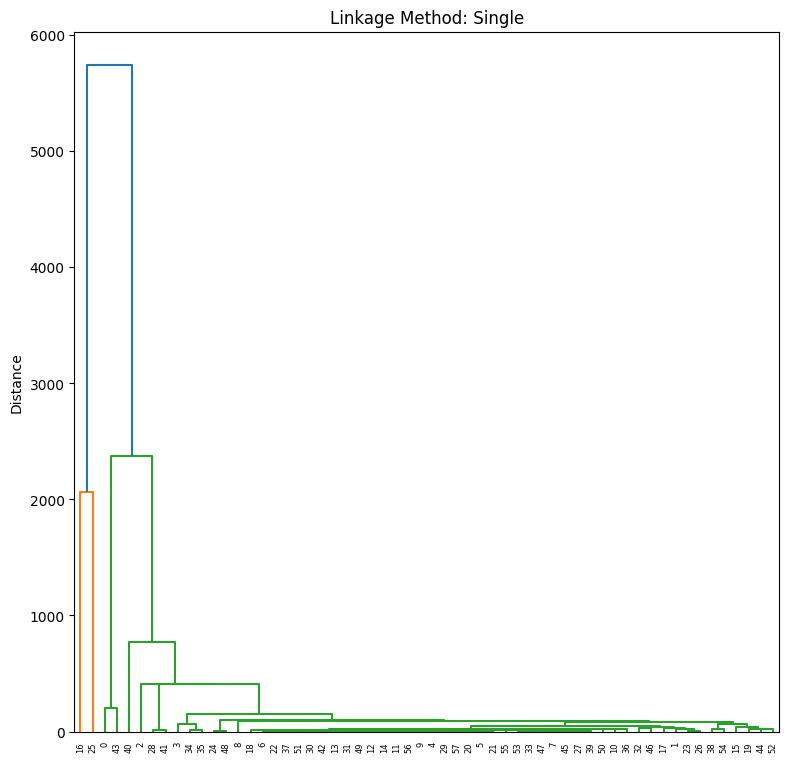

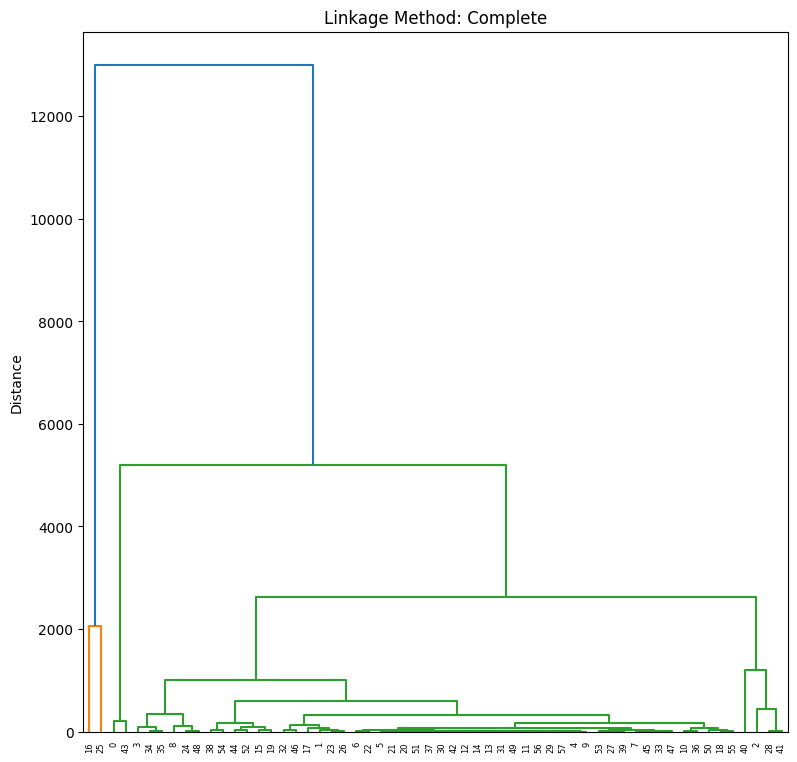

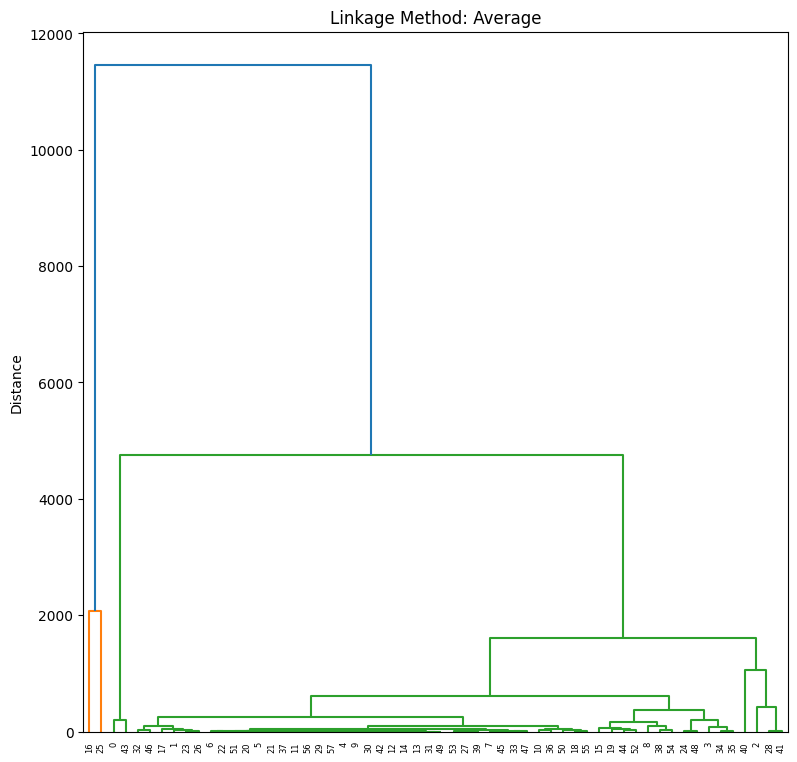

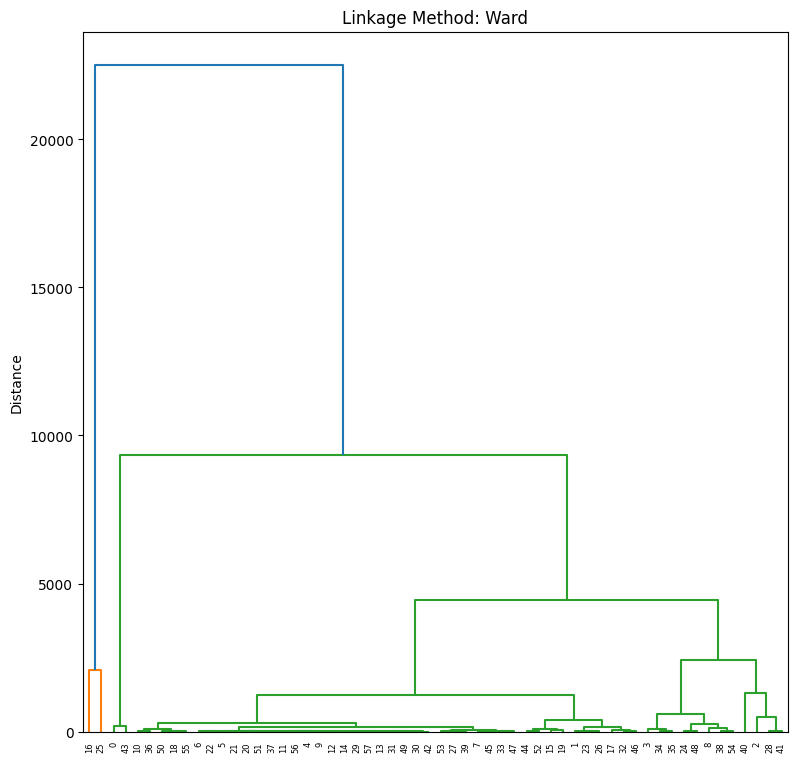

In [54]:
gene_data_path = './SMAI-Dataset-gene-expression/gene.csv'
gene_data, gene_features = read_data(gene_data_path, 1, 13)

gene_power_set_sorted = generate_power_set(gene_features)
gene_features_dict = generate_feature_dict(gene_features)

plot_dendrograms(linkage_methods, gene_features_dict, gene_power_set_sorted, gene_data)


### 3.1.2 Obeservations:
<ol>
<li><b>Single Linkage:</b>We can observe that it's highly sensitive to noise, as even a single point far from the main cluster can form its own small cluster.</li>
<br>
<li><b>Complete Linkage:</b>We can observe that it's less sensitive to noise compared to single linkage.</li>
<br>
<li><b>Average Linkage:</b>We can observe that it's less sensitive to noise and can work well for a wide range of datasets.</li>
<br>
<li><b>Ward Linkage:</b>Ward linkage is suitable for data with spherical clusters and when you want well-separated, balanced clusters.</li>
</ol>
